## 1. Load Required Libraries

In [65]:
# libraries models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# libraries feng and evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# others libraries
import src.util as utils
import yaml
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import hashlib
from tqdm import tqdm


## 2. Load Config File, Train Set, and Valid Set

In [66]:
params = utils.load_config()

In [67]:
def load_train_feng(params: dict) -> pd.DataFrame:
    # Load train set
    X_train = utils.pickle_load(params["train_feng_set_path"][0])
    y_train = utils.pickle_load(params["train_feng_set_path"][1])

    return X_train, y_train

def load_valid_feng(params: dict) -> pd.DataFrame:
    # Load valid set
    X_valid = utils.pickle_load(params["valid_feng_set_path"][0])
    y_valid = utils.pickle_load(params["valid_feng_set_path"][1])

    return X_valid, y_valid

def load_test_feng(params: dict) -> pd.DataFrame:
    # Load test set
    X_test = utils.pickle_load(params["test_feng_set_path"][0])
    y_test = utils.pickle_load(params["test_feng_set_path"][1])

    return X_test, y_test

In [68]:
X_train, y_train = load_train_feng(params)
X_valid, y_valid = load_valid_feng(params)
X_test, y_test = load_test_feng(params)

In [69]:
def load_dataset(params: dict) -> pd.DataFrame:
    # Debug message
    utils.print_debug("Loading dataset.")

    # Load train set
    X_train, y_train = load_train_feng(params)

    # Load valid set
    X_valid, y_valid = load_valid_feng(params)

    # Load test set
    X_test, y_test = load_test_feng(params)

    # Debug message
    utils.print_debug("Dataset loaded.")

    # Return the dataset
    return X_train, y_train, X_valid, y_valid, X_test, y_test

## 3. Create Training Log Model Template

In [70]:
def training_log_template() -> dict:
    # Debug message
    utils.print_debug("Creating training log template.")
    
    # Template of training log
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "data_configurations" : [],
    }

    # Debug message
    utils.print_debug("Training log template created.")

    # Return training log template
    return logger

In [71]:
def training_log_updater(current_log: dict, params: dict) -> list:
    # Create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log

## 4. Training Model

In [72]:
def create_model_object(params: dict) -> list:
    # Debug message
    utils.print_debug("Creating model objects.")

    # Create model objects
    lgr = LogisticRegression()
    dct = DecisionTreeClassifier()
    rfc = RandomForestClassifier()
    knn = KNeighborsClassifier()
    xgb = XGBClassifier()

    # Create list of model
    list_of_model = [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""}
    ]
    
    # Debug message
    utils.print_debug("Model objects created.")

    # Return the list of model
    return list_of_model

### 4.2 Training Baseline Model

In [73]:
# training models
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):
    # Load dataset
    X_train, y_train, \
    X_valid, y_valid, \
    X_test, y_test = load_dataset(params)

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in X_train:
        # Debug message
        utils.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store tained model
        trained_model = list()

        # Load train data based on its configuration
        X_train_data = X_train[config_data]
        y_train_data = y_train[config_data]

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            utils.print_debug("Training model: {}".format(model["model_name"]))

            # Training
            training_time = utils.time_stamp()
            model["model_object"].fit(X_train_data, y_train_data)
            training_time = (utils.time_stamp() - training_time).total_seconds()

            # Debug message
            utils.print_debug("Evalutaing model: {}".format(model["model_name"]))

            # Evaluation
            y_predict = model["model_object"].predict(X_valid)
            performance = classification_report(y_valid, y_predict, output_dict = True)

            # Debug message
            utils.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}".format(configuration_model, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(utils.time_stamp())
            training_log["performance"].append(performance)
            training_log["f1_score_avg"].append(performance["macro avg"]["f1-score"])
            training_log["data_configurations"].append(config_data)

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            utils.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))
        
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    # Debug message
    utils.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

In [74]:
# baseline model
list_of_trained_model, training_log = train_eval("Baseline", params)

2023-02-02 16:46:00.763650 Loading dataset.
2023-02-02 16:46:00.772773 Dataset loaded.
2023-02-02 16:46:00.772773 Creating training log template.
2023-02-02 16:46:00.772773 Training log template created.
2023-02-02 16:46:00.772773 Training model based on configuration data: Undersampling
2023-02-02 16:46:00.772773 Creating model objects.
2023-02-02 16:46:00.776780 Model objects created.
2023-02-02 16:46:00.776780 Training model: LogisticRegression
2023-02-02 16:46:00.810935 Evalutaing model: LogisticRegression
2023-02-02 16:46:00.817169 Logging: LogisticRegression
2023-02-02 16:46:00.817169 Model LogisticRegression has been trained for configuration data Undersampling.
2023-02-02 16:46:00.817169 Training model: DecisionTreeClassifier
2023-02-02 16:46:00.821498 Evalutaing model: DecisionTreeClassifier
2023-02-02 16:46:00.825452 Logging: DecisionTreeClassifier
2023-02-02 16:46:00.825452 Model DecisionTreeClassifier has been trained for configuration data Undersampling.
2023-02-02 16:46:0

C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2023-02-02 16:46:01.014472 Evalutaing model: XGBClassifier
2023-02-02 16:46:01.019768 Logging: XGBClassifier
2023-02-02 16:46:01.023852 Model XGBClassifier has been trained for configuration data Undersampling.
2023-02-02 16:46:01.037929 Training model based on configuration data: Oversampling
2023-02-02 16:46:01.037929 Creating model objects.
2023-02-02 16:46:01.037929 Model objects created.
2023-02-02 16:46:01.038927 Training model: LogisticRegression
2023-02-02 16:46:01.049393 Evalutaing model: LogisticRegression
2023-02-02 16:46:01.052544 Logging: LogisticRegression
2023-02-02 16:46:01.052544 Model LogisticRegression has been trained for configuration data Oversampling.
2023-02-02 16:46:01.052544 Training model: DecisionTreeClassifier
2023-02-02 16:46:01.054953 Evalutaing model: DecisionTreeClassifier
2023-02-02 16:46:01.056989 Logging: DecisionTreeClassifier
2023-02-02 16:46:01.058011 Model DecisionTreeClassifier has been trained for configuration data Oversampling.
2023-02-02 16:

C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2023-02-02 16:46:01.247695 Evalutaing model: XGBClassifier
2023-02-02 16:46:01.253140 Logging: XGBClassifier
2023-02-02 16:46:01.259135 Model XGBClassifier has been trained for configuration data Oversampling.
2023-02-02 16:46:01.276311 Training model based on configuration data: SMOTE
2023-02-02 16:46:01.276311 Creating model objects.
2023-02-02 16:46:01.276311 Model objects created.
2023-02-02 16:46:01.277333 Training model: LogisticRegression
2023-02-02 16:46:01.289055 Evalutaing model: LogisticRegression
2023-02-02 16:46:01.293391 Logging: LogisticRegression
2023-02-02 16:46:01.293391 Model LogisticRegression has been trained for configuration data SMOTE.
2023-02-02 16:46:01.293391 Training model: DecisionTreeClassifier
2023-02-02 16:46:01.295139 Evalutaing model: DecisionTreeClassifier
2023-02-02 16:46:01.299487 Logging: DecisionTreeClassifier
2023-02-02 16:46:01.299487 Model DecisionTreeClassifier has been trained for configuration data SMOTE.
2023-02-02 16:46:01.299487 Training 

C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2023-02-02 16:46:01.482502 Evalutaing model: XGBClassifier
2023-02-02 16:46:01.488324 Logging: XGBClassifier
2023-02-02 16:46:01.492648 Model XGBClassifier has been trained for configuration data SMOTE.
2023-02-02 16:46:01.506508 All combination models and configuration data has been trained.


### 4.3 Choose Best Performance Baseline Model

In [75]:
def get_production_model(list_of_model, training_log, params):
    # Create copy list of model
    list_of_model = copy.deepcopy(list_of_model)
    
    # Debug message
    utils.print_debug("Choosing model by metrics score.")

    # Create required predefined variabel
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    utils.print_debug("Converting training log type of data from dict to dataframe.")

    # Convert dictionary to pandas for easy operation
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    utils.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = utils.pickle_load(params["production_model_path"])
        utils.print_debug("Previous production model loaded.")

    except FileNotFoundError as fe:
        utils.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        utils.print_debug("Loading validation data.")
        X_valid, y_valid = load_valid_feng(params)
        
        # Debug message
        utils.print_debug("Checking compatibilty previous production model's input with current train data's features.")

        # Check list features of previous production model and current dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(X_valid.columns)
        number_of_different_features = len((production_model_features - current_dataset_features) | (current_dataset_features - production_model_features))

        # If feature matched:
        if number_of_different_features == 0:
            # Debug message
            utils.print_debug("Features compatible.")

            # Debug message
            utils.print_debug("Reassesing previous model performance using current validation data.")

            # Re-predict previous production model to provide valid metrics compared to other current models
            y_pred = prev_production_model["model_data"]["model_object"].predict(X_valid)

            # Re-asses prediction result
            eval_res = classification_report(y_valid, y_pred, output_dict = True)

            # Debug message
            utils.print_debug("Assessing complete.")

            # Debug message
            utils.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["performance"] = eval_res
            prev_production_model["model_log"]["f1_score_avg"] = eval_res["macro avg"]["f1-score"]

            # Debug message
            utils.print_debug("Adding previous model data to current training log and list of model")

            # Added previous production model log to current logs to compere who has the greatest f1 score
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # Added previous production model to current list of models to choose from if it has the greatest f1 score
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]
        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            utils.print_debug("Different features between production model with current dataset is detected, ignoring production dataset.")

    # Debug message
    utils.print_debug("Sorting training log by f1 macro avg and training time.")

    # Sort training log by f1 score macro avg and trining time
    best_model_log = training_log.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    # Debug message
    utils.print_debug("Searching model data based on sorted training log.")

    # Get model object with greatest f1 score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Production-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break
    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    # Debug message
    utils.print_debug("Model chosen.")

    # Dump chosen production model
    utils.pickle_dump(curr_production_model, params["production_model_path"])
    
    # Return current chosen production model, log of production models and current training log
    return curr_production_model, production_model_log, training_log      
        

In [76]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2023-02-02 16:46:01.649608 Choosing model by metrics score.
2023-02-02 16:46:01.649608 Converting training log type of data from dict to dataframe.
2023-02-02 16:46:01.652607 Trying to load previous production model.
2023-02-02 16:46:01.653610 Previous production model loaded.
2023-02-02 16:46:01.653610 Loading validation data.
2023-02-02 16:46:01.655197 Checking compatibilty previous production model's input with current train data's features.
2023-02-02 16:46:01.655197 Features compatible.
2023-02-02 16:46:01.655197 Reassesing previous model performance using current validation data.
2023-02-02 16:46:01.659206 Assessing complete.
2023-02-02 16:46:01.659206 Storing new metrics data to previous model structure.
2023-02-02 16:46:01.659206 Adding previous model data to current training log and list of model
2023-02-02 16:46:01.662701 Sorting training log by f1 macro avg and training time.
2023-02-02 16:46:01.664701 Searching model data based on sorted training log.
2023-02-02 16:46:01.66

## 5. Evalution and Metrics

### 5.1 Hyperparameter Tuning

In [77]:
def create_dist_params(model_name: str) -> dict:
    # Define models paramteres
    dist_params_xgb = {
        "n_estimators" : [50, 100, 200, 300, 400, 500]
    }
    dist_params_dct = {
        "algorithm" : ["gini", "entropy", "log_loss"],
        "min_sample_split" : [1, 2, 4, 6, 10, 15, 20, 25],
        "min_sample_leaf" : [1, 2, 4, 6, 10, 15, 20, 25]
    }
    dist_params_knn = {
        "creterion" : ["ball_tree", "kd_tree", "brute"],
        "n_neighbors" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
        "leaf_size" : [2, 3, 4, 5, 6, 10, 15, 20, 25],
    }
    dist_params_lgr = {
        "penalty" : ["l1", "l2", "elasticnet", "none"],
        "C" : [0.01, 0.05, 0.10, 0.15, 0.20, 0.30, 0.60, 0.90, 1],
        "solver" : ["saga"],
        "max_iter" : [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
    }
    dist_params_rfc = {
        "algorithm" : ["gini", "entropy", "log_loss"],
        "n_estimators" : [50, 100, 200, 300, 400, 500],
        "min_sample_split" : [1, 2, 4, 6, 10, 15, 20, 25],
        "min_sample_leaf" : [1, 2, 4, 6, 10, 15, 20, 25]
    }

    # Make all models parameters in to one
    dist_params = {
        "XGBClassifier": dist_params_xgb,
        "DecisionTreeClassifier": dist_params_dct,
        "KNeighborsClassifier": dist_params_knn,
        "LogisticRegression": dist_params_lgr,
        "RandomForestClassifier": dist_params_rfc
    }

    # Return distribution of model parameters
    return dist_params[model_name]

In [78]:
def hyper_params_tuning(model: dict) -> list:
    # Create copy of current best baseline model
    model = copy.deepcopy(model)

    # Create model's parameter distribution
    dist_params = create_dist_params(model["model_data"]["model_name"])

    # Create model object
    model_rsc = RandomizedSearchCV(model["model_data"]["model_object"], dist_params, n_jobs = -1)
    model_data = {
        "model_name": model["model_data"]["model_name"],
        "model_object": model_rsc,
        "model_uid": ""
    }
    
    # Return model object
    return [model_data]

In [79]:
list_of_trained_model, training_log = train_eval("Hyperparams_Tuning", params, hyper_params_tuning(model))

2023-02-02 16:46:01.803935 Loading dataset.
2023-02-02 16:46:01.809930 Dataset loaded.
2023-02-02 16:46:01.809930 Creating training log template.
2023-02-02 16:46:01.809930 Training log template created.
2023-02-02 16:46:01.809930 Training model based on configuration data: Undersampling
2023-02-02 16:46:01.809930 Training model: LogisticRegression


C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn(some_fits_failed_message, FitFailedWarning)

2023-02-02 16:46:04.542444 Evalutaing model: LogisticRegression
2023-02-02 16:46:04.546447 Logging: LogisticRegression
2023-02-02 16:46:04.546447 Model LogisticRegression has been trained for configuration data Undersampling.
2023-02-02 16:46:04.546447 Training model based on configuration data: Oversampling
2023-02-02 16:46:04.547450 Training model: LogisticRegression
2023-02-02 16:46:04.671973 Evalutaing model: LogisticRegression
2023-02-02 16:46:04.674973 Logging: LogisticRegression
2023-02-02 16:46:04.674973 Model LogisticRegression has been trained for configuration data Oversampling.
2023-02-02 16:46:04.674973 Training model based on configuration data: SMOTE
2023-02-02 16:46:04.674973 Training model: LogisticRegression
2023-02-02 16:46:04.858353 Evalutaing model: LogisticRegression
2023-02-02 16:46:04.862353 Logging: LogisticRegression
2023-02-02 16:46:04.862353 Model LogisticRegression has been trained for configuration data SMOTE.
2023-02-02 16:46:04.862353 All combination mod

C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ramad\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py", line 1101, in fit
    raise ValueError(
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  warnings.warn(some_fits_failed_message, FitFailedWarning)

In [80]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2023-02-02 16:46:04.895361 Choosing model by metrics score.
2023-02-02 16:46:04.895361 Converting training log type of data from dict to dataframe.
2023-02-02 16:46:04.896361 Trying to load previous production model.
2023-02-02 16:46:04.902889 Previous production model loaded.
2023-02-02 16:46:04.902964 Loading validation data.
2023-02-02 16:46:04.903970 Checking compatibilty previous production model's input with current train data's features.
2023-02-02 16:46:04.903970 Features compatible.
2023-02-02 16:46:04.903970 Reassesing previous model performance using current validation data.
2023-02-02 16:46:04.906969 Assessing complete.
2023-02-02 16:46:04.906969 Storing new metrics data to previous model structure.
2023-02-02 16:46:04.906969 Adding previous model data to current training log and list of model
2023-02-02 16:46:04.908966 Sorting training log by f1 macro avg and training time.
2023-02-02 16:46:04.909969 Searching model data based on sorted training log.
2023-02-02 16:46:04.91

### 5.2 Confusion Matrix

In [81]:
X_valid, y_valid = load_valid_feng(params)

In [82]:
y_pred = model["model_data"]["model_object"].predict(X_valid)

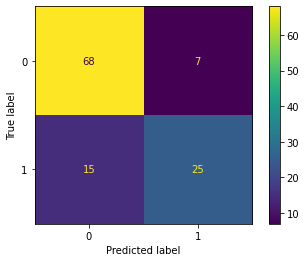

In [83]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)